<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 3: Sem2 AY 23/24 - DQN for Atari

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
| Sl. No. | Test case                             | Status |
|---------|---------------------------------------|--------|
| 1.      | [Imports and setup](#Imports-and-setup)  | <span style='color: #0e0'>Passed<span> |
| 2.      | [Capture and sampling of the data](#Capture-and-sampling-of-data) | <span style='color: #3af'>Awaiting</span> |
| 3.      | [Network structure and hyperparameters](#Network-structure-and-hyperparameters) | <span style='color: #3af'>Awaiting</span> |
| 4.      | [Q-learning updates](#Q-learning-updates) | <span style='color: #3af'>Awaiting</span> |
| 5.      | [Metrics and evalutation](#Metrics-and-evalutation) | <span style='color: #3af'>Awaiting</span> |
| 6.      | [Finetuning](#Finetuning) | <span style='color: #3af'>Awaiting</span> |
|   6.1      | [Experimenting with Double DQN](#Experimenting-with-Double-DQN) | <span style='color: #3af'>Awaiting</span> |
|   6.2      | [Experimenting with Dueling DQN](#Experimenting-with-Dueling-DQN) | <span style='color: #3af'>Awaiting</span> |

## References
- [DQN Tutorial | Pytorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [Github: GiannisMitr/DQN-Atari-Breakout](https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb)
- [Github: KJ-Waller/DQN-PyTorch-Breakout](https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py)
- [A Geron's Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow - Chapter 18 Reinforcement Learning sample notebook](https://github.com/ageron/handson-ml2/blob/8958d538bdcdf29d329d9950bfc79034c29db724/18_reinforcement_learning.ipynb)

## Imports and setup

In [1]:
# Common imports
import sys
import numpy as np
import os
from collections import namedtuple, deque

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# ML lib imports
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# OpenAI Gym import
import gym

import warnings 
warnings.filterwarnings('ignore') # To ignore the big red future warnings (for now and convenience)

In [2]:
# Version checks
assert sys.version_info >= (3,10)
assert sklearn.__version__ >= "0.20" # Scikit-Learn ≥0.20 is required

# to make this notebook's output stable across runs
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Get available device for training
device = ( "cuda"     # CUDA for GPU compute
           if torch.cuda.is_available()
           else "cpu (not dice)" )   # CPU won't cut it. :P

print(f"{device} device available")

cuda device available


### Utility methods

In [4]:
# Utility methods

# Method that plots the current state of the environment as an image
# Taken from Geron's ml2 RL example notebook
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # returns an image of the environment as a Numpy array. 
    # 'rgb-array' mode does this instead of opening a separate window that renders the image.
    img = env.render(mode="rgb_array")
    plt.imshow(img) # shows the image as a plot via Matplotlib's pyplot module in the cell output
    plt.axis("off") # does not display the plot axes and just the image.
    return img

# Method sets the current frame to be plotted for the corresponding frame in the animation
# Taken from Geron's ml2 RL example notebook
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Method that plots an animation of the environment that cycles through each frame that corresponds to each step taken
# Taken from Geron's ml2 RL example notebook
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # uses matplotlib's animation module. The FuncAnimation method repeatedly calls a specified method for the number of 
    # provided frames. The specified function that is called, 'update_scene' is defined above.
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

### Gym environment setup
Listing all the available OpenAI Gym environments to explore

In [5]:
allEnvs = gym.envs.registry.all() # Getting a list of all available gym environments and their specifications
envIds = [envSpec.id for envSpec in allEnvs] # Getting the id names for each environment's specification
print(sorted(envIds))

['ALE/Adventure-ram-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-ram-v5', 'ALE/AirRaid-v5', 'ALE/Alien-ram-v5', 'ALE/Alien-v5', 'ALE/Amidar-ram-v5', 'ALE/Amidar-v5', 'ALE/Assault-ram-v5', 'ALE/Assault-v5', 'ALE/Asterix-ram-v5', 'ALE/Asterix-v5', 'ALE/Asteroids-ram-v5', 'ALE/Asteroids-v5', 'ALE/Atlantis-ram-v5', 'ALE/Atlantis-v5', 'ALE/Atlantis2-ram-v5', 'ALE/Atlantis2-v5', 'ALE/Backgammon-ram-v5', 'ALE/Backgammon-v5', 'ALE/BankHeist-ram-v5', 'ALE/BankHeist-v5', 'ALE/BasicMath-ram-v5', 'ALE/BasicMath-v5', 'ALE/BattleZone-ram-v5', 'ALE/BattleZone-v5', 'ALE/BeamRider-ram-v5', 'ALE/BeamRider-v5', 'ALE/Berzerk-ram-v5', 'ALE/Berzerk-v5', 'ALE/Blackjack-ram-v5', 'ALE/Blackjack-v5', 'ALE/Bowling-ram-v5', 'ALE/Bowling-v5', 'ALE/Boxing-ram-v5', 'ALE/Boxing-v5', 'ALE/Breakout-ram-v5', 'ALE/Breakout-v5', 'ALE/Carnival-ram-v5', 'ALE/Carnival-v5', 'ALE/Casino-ram-v5', 'ALE/Casino-v5', 'ALE/Centipede-ram-v5', 'ALE/Centipede-v5', 'ALE/ChopperCommand-ram-v5', 'ALE/ChopperCommand-v5', 'ALE/CrazyClimber-ram-v5'

We are choosing the _**`ALE/Breakout-v5`**_ gym environment because it simply has a good track record of being solved by DQNs. It was famously the first demonstration made by Google's DeepMind for a DQN agent. The full environment specification description is as follows:  
### ALE/Breakout-v5 Specification:
#### Description:
The below exceprt is taken from the [Gymnasium documentation](https://gymnasium.farama.org/environments/atari/breakout/) on the Breakout Atari environment.  
  
"The dynamics are similar to pong: You move a paddle and hit the ball in a brick wall at the top of the screen. Your goal is to destroy the brick wall. You can try to break through the wall and let the ball wreak havoc on the other side, all on its own! You have five lives."
#### Action Space:
- The action space is discrete.
- By default, all actions that can be performed on an Atari 2600 are available in this environment. These actions are:
|Value|Meaning|Value|Meaning|Value|Meaning|
|-----|-------|-----|-------|-----|-------|
|`0`|`NOOP`|`1`|`FIRE`|`2`|`UP`|
|`3`|`RIGHT`|`4`|`LEFT`|`5`|`DOWN`|
|`6`|`UPRIGHT`|`7`|`UPLEFT`|`8`|`DOWNRIGHT`|
|`9`|`DOWNLEFT`|`10`|`UPFIRE`|`11`|`RIGHTFIRE`|
|`12`|`LEFTFIRE`|`13`|`DOWNFIRE`|`14`|`UPRIGHTFIRE`|
|`15`|`UPLEFTFIRE`|`16`|`DOWNRIGHTFIRE`|`17`|`DOWNLEFTFIRE`|

- However, for the Breakout environment only 4 discrete actions from the above are meaningful. These are as follows:
 |Value|Meaning|Value|Meaning|Value|Meaning|
|-----|-------|-----|-------|-----|-------|
|`0`|`NOOP`|`1`|`FIRE`|`2`|`RIGHT`|
|`3`|`LEFT`|||||

- The above actions are self-explanatory with `LEFT` and `RIGHT` to move the paddle across the screen in the respective directions. `FIRE` is to serve a ball and get a round started. The player has 5 balls per game. `NOOP` is the usual no operation.
#### Observation Space:
- The observation space is an RGB image (colour image) with dimensions (210, 160, 3).
- Each pixel in the image represents a colour value (ranging from 0 to 255) for red, green, and blue channels.
- It can also be observed by the grayscale version of the image, which has dimensions (210, 160).
#### Rewards:
- Points are scored by destroying bricks in the wall.
- The reward for destroying a brick depends on the color of the brick. They are as follows as seen from the [Atariage documentation for Breakout](https://atariage.com/manual_html_page.php?SoftwareID=889).  
|Brick Colour|Points|Brick Colour|Points|Brick Colour|Points|
|------------|------|------------|------|------------|------|
|Red|7|Orange|7|Yellow|4|
|Green|4|Aqua|1|Blue|1|

#### Starting State:
The starting state of Breakout is with the paddle in the middle and 6 layers of bricks with blue being the lowest layer and red being the highest. Pressing `FIRE` serves the ball to get the game started.

#### Episode Termination/Objective:
The episode finishes if:
- If the ball goes out of bounds. Though there are 5 lives, losing one life terminates it ensure the agent learns to not loose lives.
- All the bricks in the wall are destroyed and the maximum score of `864` is reached.

In [13]:
# Setting the gym environment
# setting to the Breakout environment with only the reduced action space and rendering the frames in grayscale.
env = gym.make('ALE/Breakout-v5', full_action_space=False) 
obs = env.reset(seed=SEED) # initialising the environment with the reset() method 

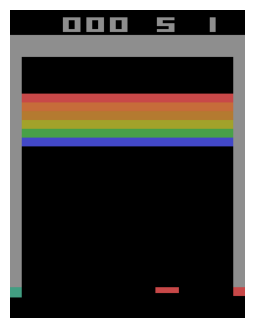

In [14]:
# Testing the rendering of Breakout's environment
plot_environment(env)
plt.show()

## Capture and sampling of data

In [15]:
env.action_space

Discrete(4)

In [16]:
# Testing out an action step to get familiar with the values we're working with
action = 1  # Initate game by "firing" the ball i.e, serving the ball
obs, reward, done, info = env.step(action)

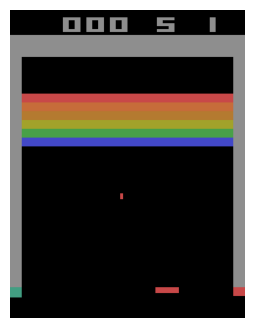

In [17]:
# Plotting the environment again to check the change in the observed state
plot_environment(env)
plt.show()

The ball has been served in the above frame after the next step.

In [18]:
# Checking the reward obtained. The reward is zero as no brick has been destroyed yet.
reward

0.0

### Testing the env with a random policy
We just want to randomly sample an action step from the 4 available actions to see how it renders (and test if the animation works).

In [19]:
# Reset the environment to get the initial observation
obs = env.reset(seed=SEED)

frames = []
episodeReward = 0
for step in range(200): # running this for 200 frames
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)
    episodeReward += reward
    if done:
        break

In [20]:
# plot the animation from all the frames (steps) captured
plot_animation(frames)

In [21]:
len(frames)

189

The random policy crashed in 144 steps.

## Network structure and hyperparameters

In [22]:
env.action_space.n

4

In [23]:
n_observations = env.observation_space.shape
n_outputs = env.action_space.n

# DQN model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Define fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        x = x.float() / 255  # Normalize input
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [24]:
policy_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())

Defining the action policy function

In [25]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        state = torch.tensor(state, dtype=torch.float32, device=device)
        Q_values = model(state)
        Q_values = Q_values.detach().cpu().numpy()
        return np.argmax(Q_values[0])

Replay memory system

In [26]:
replay_memory = deque(maxlen=2000)

Function to sample experiences from replay memory

In [27]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [28]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Training function

In [29]:
batch_size = 32
discount_rate = 0.95
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # Compute Q-values for next states
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    next_Q_values = policy_net(next_states)
    max_next_Q_values, _ = torch.max(next_Q_values, dim=1)

    # Compute target Q-values
    max_next_Q_values = max_next_Q_values.detach().cpu().numpy()
    target_Q_values = np.sum((rewards, (1 - dones) * discount_rate * max_next_Q_values))
    target_Q_values = torch.tensor(target_Q_values, dtype=torch.float32, device=device)
    target_Q_values = target_Q_values.view(-1, 1)

    # Create a one-hot mask for actions
    mask = torch.zeros(len(actions), n_outputs, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    mask.scatter_(1, actions.view(-1, 1), 1)

    # Compute Q-values for current states
    states = torch.tensor(states, dtype=torch.float32, device=device)
    all_Q_values = model(states)
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdim=True)
    
    # Compute loss
    loss = torch.mean((target_Q_values - Q_values) ** 2)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

NameError: name 'model' is not defined

## Q-learning updates

In [25]:
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

rewards = [] 
best_score = 0

In [26]:
for episode in range(600):
    obs = env.reset(seed=SEED)    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.state_dict() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.load_state_dict(best_weights)

Episode: 0, Steps: 195, eps: 1.000

RuntimeError: mat1 and mat2 shapes cannot be multiplied (33600x3 and 210x128)

## Metrics and evalutation

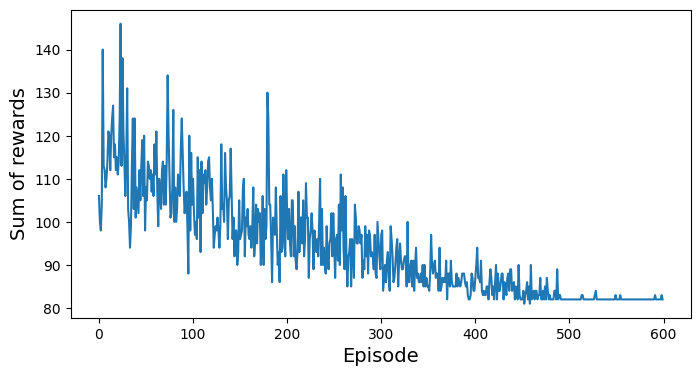

In [227]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("dqn_rewards_plot")
plt.show()

In [228]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

## Finetuning

### Experimenting with Double DQN

### Experimenting with Dueling DQN